![vgu_campus.png](..\images\fscampus_small2.png)

***Finance III (PFIN)-SS2025***

**Dr. Omer Cayirli**

Lecturer in Empirical Finance

omer.cayirli@vgu.edu.vn

---

## Lecture 03
---

### Outline
* Capital markets and the pricing of risk

* Optimal portfolio choice and the Capital Asset Pricing model

* Estimating the cost of capital

---

### Risk in Investments

**Two fundamental questions for investments:**

* What is risk and how can we measure it?

* How much additional return should we earn for bearing an additional unit of risk?

---

Fetching daily data from 1999-12-31 to 2025-05-03
Data will be resampled to monthly. Using QQQ close vs. adjusted for Nasdaq-100.


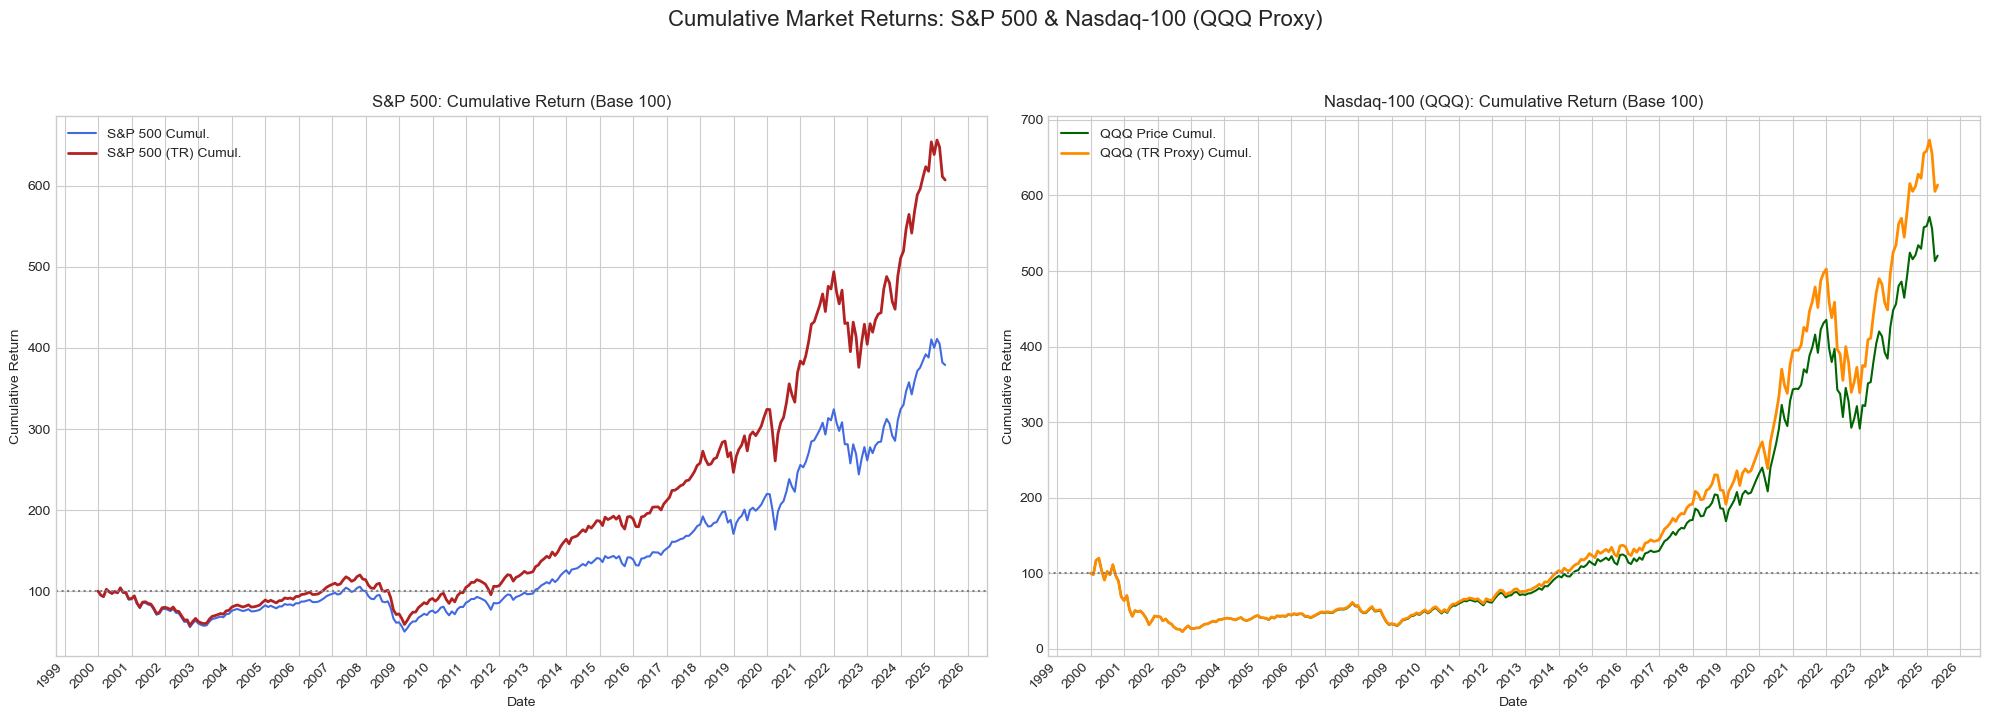

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date, timedelta

# --- 1. Define Tickers and Date Range ---
tickers_base = ['^GSPC', '^SP500TR']
start_date = "1999-12-31"

today = date.today()
first_day_of_current_month = today.replace(day=1)
end_date_dt = first_day_of_current_month - timedelta(days=1)
end_date_str = end_date_dt.strftime('%Y-%m-%d')
yf_end_date = (end_date_dt + timedelta(days=3)).strftime('%Y-%m-%d')

print(f"Fetching daily data from {start_date} to {yf_end_date}")
print("Data will be resampled to monthly. Using QQQ close vs. adjusted for Nasdaq-100.")

# --- 2. Download Daily Data and Resample to Monthly ---
downloaded_monthly_series = {}

for ticker in tickers_base:
    try:
        daily_data = yf.download(
            ticker,
            start=start_date,
            end=yf_end_date,
            progress=False,
            auto_adjust=True
        )
        if not daily_data.empty and 'Close' in daily_data.columns:
            monthly = daily_data['Close'].resample('ME').last()
            monthly = monthly[monthly.index <= pd.to_datetime(end_date_str)]
            if len(monthly) > 1:
                downloaded_monthly_series[ticker] = monthly.copy()
    except Exception as e:
        print(f"Failed {ticker}: {e}")

try:
    ticker = 'QQQ'
    daily_raw = yf.download(
        ticker,
        start=start_date,
        end=yf_end_date,
        progress=False,
        auto_adjust=False 
    )
    if not daily_raw.empty and 'Close' in daily_raw.columns:
        monthly_raw = daily_raw['Close'].resample('ME').last()
        monthly_raw = monthly_raw[monthly_raw.index <= pd.to_datetime(end_date_str)]
        if len(monthly_raw) > 1:
            downloaded_monthly_series['QQQ_raw'] = monthly_raw.copy()
except Exception as e:
    print(f"Failed QQQ raw: {e}")

try:
    ticker = 'QQQ'
    daily_adj = yf.download(
        ticker,
        start=start_date,
        end=yf_end_date,
        progress=False,
        auto_adjust=True 
    )
    if not daily_adj.empty and 'Close' in daily_adj.columns:
        monthly_adj = daily_adj['Close'].resample('ME').last()
        monthly_adj = monthly_adj[monthly_adj.index <= pd.to_datetime(end_date_str)]
        if len(monthly_adj) > 1:
            downloaded_monthly_series['QQQ_adj'] = monthly_adj.copy()
except Exception as e:
    print(f"Failed QQQ adj: {e}")

# --- 3. Combine into DataFrame ---
price_data_processed = pd.DataFrame()
if downloaded_monthly_series:
    try:
        price_data_processed = pd.concat(downloaded_monthly_series, axis=1)
        if isinstance(price_data_processed.columns, pd.MultiIndex):
            price_data_processed.columns = price_data_processed.columns.get_level_values(0)
        price_data_processed.sort_index(inplace=True)
        price_data_processed.dropna(how='all', inplace=True)
    except Exception as ex:
        print(f"Error creating DataFrame: {ex}")
else:
    print("No data to combine.")

if price_data_processed.empty:
    print("No data available. Exiting.")
    raise SystemExit

# --- 4. Prepare for Plotting ---
rename_map = {
    '^GSPC':      'S&P 500',
    '^SP500TR':  'S&P 500 (TR)',
    'QQQ_raw':   'QQQ Price',
    'QQQ_adj':   'QQQ (TR Proxy)'
}
price_data_processed.rename(columns=rename_map, inplace=True)
price_data_processed.index = pd.to_datetime(price_data_processed.index)

sp500_price = rename_map.get('^GSPC') # Use .get to avoid KeyError if a ticker failed
sp500_tr    = rename_map.get('^SP500TR')
nas_raw     = rename_map.get('QQQ_raw')
nas_tr      = rename_map.get('QQQ_adj')

# --- 5. Plot ---
plt.style.use('seaborn-v0_8-whitegrid')
# Create two subplots side-by-side for cumulative returns
fig, ax = plt.subplots(1, 2, figsize=(20, 7), sharex=True) # 1 row, 2 columns

def has(df, col):
    return col is not None and col in df.columns and df[col].notna().any()

# S&P 500 Cumulative Return (Left Plot)
if has(price_data_processed, sp500_price) and has(price_data_processed, sp500_tr):
    p0 = price_data_processed[sp500_price].dropna().iloc[0] if price_data_processed[sp500_price].notna().any() else None
    t0 = price_data_processed[sp500_tr].dropna().iloc[0] if price_data_processed[sp500_tr].notna().any() else None
    if p0 is not None and t0 is not None:
        ax[0].plot(price_data_processed.index,
                     price_data_processed[sp500_price]/p0*100,
                     label=f'{sp500_price} Cumul.', color='royalblue', lw=1.5)
        ax[0].plot(price_data_processed.index,
                     price_data_processed[sp500_tr]/t0*100,
                     label=f'{sp500_tr} Cumul.', color='firebrick', lw=2)
        ax[0].axhline(100, color='grey', ls=':')
ax[0].set_title('S&P 500: Cumulative Return (Base 100)')
ax[0].set_ylabel('Cumulative Return')
ax[0].set_xlabel('Date')
ax[0].legend(loc='upper left')
ax[0].grid(True)

# Nasdaq-100 Cumulative Return (Right Plot)
if has(price_data_processed, nas_raw) and has(price_data_processed, nas_tr):
    r0 = price_data_processed[nas_raw].dropna().iloc[0] if price_data_processed[nas_raw].notna().any() else None
    a0 = price_data_processed[nas_tr].dropna().iloc[0] if price_data_processed[nas_tr].notna().any() else None
    if r0 is not None and a0 is not None:
        ax[1].plot(price_data_processed.index,
                     price_data_processed[nas_raw]/r0*100,
                     label=f'{nas_raw} Cumul.', color='darkgreen', lw=1.5)
        ax[1].plot(price_data_processed.index,
                     price_data_processed[nas_tr]/a0*100,
                     label=f'{nas_tr} Cumul.', color='darkorange', lw=2)
        ax[1].axhline(100, color='grey', ls=':')
ax[1].set_title('Nasdaq-100 (QQQ): Cumulative Return (Base 100)')
ax[1].set_ylabel('Cumulative Return')
ax[1].set_xlabel('Date')
ax[1].legend(loc='upper left')
ax[1].grid(True)

# Format x-axis for both plots
for i in [0,1]:
    ax[i].xaxis.set_major_locator(mdates.YearLocator())
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax[i].xaxis.set_minor_locator(mdates.MonthLocator(interval=6))
    plt.setp(ax[i].get_xticklabels(), rotation=45, ha='right')

fig.suptitle('Cumulative Market Returns: S&P 500 & Nasdaq-100 (QQQ Proxy)', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()




---

### Expected and Excess Returns on Investments

**Expected Return**
* The level of total return realized during the holding period involves uncertainty.

* The expected rate of return is the probability-weighted average of the rates of return that will occur in each scenario.

**Excess Return** 
* The additional return an asset provides over a risk-free rate.

**Expected Excess Return** 

* The probability-weighted average of all possible excess returns.



---

### Risk in Investments

* One of the main functions of financial markets is to enable economic agents to transfer their risks to willing counterparties or to assume the risks of others.

* Financial risks are generally associated with uncertainty about the outcome of an investment.
    * Volatility (variance) in returns is the main risk criterion used.

    * Risk measures are not limited to volatility:
        * Value at Risk (VaR)
            * Measures the potential loss in value of a risky asset or portfolio over a defined period for a given confidence interval.
            * What is the most I can expect to lose, X% of the time, over a specific holding period?
        * Conditional Value at Risk (CVaR) / Expected Shortfall (ES)
            * What is the expected loss, conditional on the loss exceeding the VaR?
            * Quantifies the losses that might be encountered in the tail.
        * Semivariance
            * Measures the dispersion of all observations that fall below the mean or target value of a set of data.

---

### Risk in Investments

*   Modern portfolio theory and asset pricing models often begin with the assumption of a normal distribution of returns.
*   The normality assumption ensures that the standard deviation is an exact measure of risk.
*   A normal distribution;
    *   Fully defined by its mean ($\mu$) and variance ($\sigma^2$).
    *   Symmetrical, bell-shaped curve.
*   The mean of the standard normal distribution is 0 and the variance is 1.
    *   The mean or expected value ($\mu$) of the distribution is known as the location parameter.
    *   A normal distribution with $\mu \ne 0$ can be easily converted to a standard normal distribution ($\mu=0, \sigma=1$).
    *   The standard deviation ($\sigma$) of the distribution is known as the distribution parameter.
    *   When $\mu$ is constant, changes in distribution parameter affect the shape of the distribution.

<center>
<img src="../figures/location_and_scale.png" width="840"/>
</center>

---

<center>
<img src="../figures/historical_risk_return.png" width="1080"/>
</center>

---

### Risk in Investments

**Portfolio Return**

$$ E(r_p) = w_1 E(r_1) + w_2 E(r_2) + \dots + w_N E(r_N) \quad \Rightarrow \quad E(r_p) = \sum_{n=1}^{N} w_n E(r_n) $$

**Portfolio Risk**

$$ \sigma^2(r_p) = p_1 \cdot (r_{p,1} - E(r_p))^2 + p_{2} \cdot (r_{p,2} - E(r_p))^2 + \dots + p_{n} \cdot (r_{p,n} - E(r_p))^2 \quad \text{and} \quad \sigma_p = \sqrt{\sigma^2(r_p)} $$

* For an asset, the variance is a measure of the dispersion of possible returns on the asset around the expected return.

* Similarly, portfolio variance measures the dispersion of possible portfolio returns around the expected portfolio return.

* **How should we calculate the standard deviation (risk) of the portfolio consisting of these two assets?**

---

### Risk in Investments

*   When calculating the expected return of the portfolio, we take the weighted average of the expected returns of the assets.

*   We cannot use the same method for variance or standard deviation (i.e., simply taking a weighted average of individual asset variances is incorrect due to the effect of covariances).

*   **Covariance:**
    *   Measures the directional relationship between the returns of two assets.
    *   At the portfolio level, the sign and magnitude of the covariances between pairs of assets significantly impact the overall volatility (risk) of the portfolio.

*   For two assets, $i$ and $j$, when considering $N$ possible states of the world (scenarios), each with a probability $p_k$:

    $ \text{Cov}(r_i, r_j) = p_1 \cdot [r_{i,1} - E(r_i)] \cdot [r_{j,1} - E(r_j)] + p_2 \cdot [r_{i,2} - E(r_i)] \cdot [r_{j,2} - E(r_j)] + \dots + p_N \cdot [r_{i,N} - E(r_i)] \cdot [r_{j,N} - E(r_j)] $

    $ \text{Cov}(r_i, r_j) = \sum_{k=1}^{N} p_k \cdot [r_{i,k} - E(r_i)] \cdot [r_{j,k} - E(r_j)] $
    
    Where:
    *   $\text{Cov}(r_i, r_j)$ is the covariance between the returns of asset $i$ and asset $j$.
    *   $N$ is the number of possible states/scenarios and $p_k$ is the probability of state/scenario $k$ occurring.
    *   $r_{i,k}$ is the return of asset $i$ if state/scenario $k$ occurs and $E(r_i)$ is the expected return of asset $i$.
    *   $r_{j,k}$ is the return of asset $j$ if state/scenario $k$ occurs and $E(r_j)$ is the expected return of asset $j$.

---


### Risk in Investments

*   **Correlation Coefficient ($\rho_{i,j}$):**
    *   A standardized measure of the linear relationship between two assets' returns ($r_i, r_j$).
    *   Standardizes covariance: $\text{Cov}(r_i, r_j)$, easier to interpret than covariance.
    *   Values range from **-1 to +1**.

    $$ \rho_{i,j} = \frac{\operatorname{Cov}(r_i, r_j)}{\sigma_i\,\sigma_j}, \quad \text{where }\; \sigma_i \text{ and } \; \sigma_j  \text{ are the standard deviations of assets }i\text{ and }j. $$


    *   Covariance can be found using correlation: 
    $$\text{Cov}(r_i, r_j) = \rho_{i,j} \sigma_i \sigma_j$$
    *   For two assets (portfolio variance $\sigma_p^2$):
        $$ \sigma_p^2 = w_1^2\sigma_1^2 + w_2^2\sigma_2^2 + 2w_1w_2\rho_{12}\sigma_1\sigma_2 $$

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- Input Parameter Widgets ---
# Style for descriptions (labels)
style_desc = {'description_width': '200px'} # Consistent description width

# Layout for the input FloatText fields themselves (the box part)
input_field_layout = widgets.Layout(width='130px') # Make input boxes a bit wider for cov

# Combined layout for description + input field for FloatText
# Total width needed: description_width + input_field_layout.width + some padding
widget_layout_left = widgets.Layout(width='350px') # Overall widget width for left column
widget_layout_right = widgets.Layout(width='350px')# Overall widget width for right column

er_a_widget = widgets.FloatText(value=0.1010, step=0.0001, description='Expected Return Asset A (E(rA)):', style=style_desc, layout=widget_layout_left)
std_a_widget = widgets.FloatText(value=0.0170, step=0.0001, description='Std. Dev. Asset A (σA):', style=style_desc, layout=widget_layout_left)
# Correlation: default -0.8986 from your image
corr_ab_widget = widgets.FloatText(value=-0.8986, step=0.0001, min=-1, max=1, description='Correlation (ρAB):', style=style_desc, layout=widget_layout_left)
# Covariance: default -0.000388 from your image, ensure format for display
cov_ab_widget = widgets.FloatText(value=-0.000388, step=0.000001, description='Covariance (Cov(rA, rB)):', style=style_desc, layout=widget_layout_left)


er_b_widget = widgets.FloatText(value=0.0940, step=0.0001, description='Expected Return Asset B (E(rB)):', style=style_desc, layout=widget_layout_right)
std_b_widget = widgets.FloatText(value=0.0254, step=0.0001, description='Std. Dev. Asset B (σB):', style=style_desc, layout=widget_layout_right)


# --- Output Widgets ---
output_gmvp = widgets.Output()
output_table = widgets.Output()
output_plot = widgets.Output()

# --- Recalculate Button ---
recalculate_button = widgets.Button(
    description="Recalculate & Plot",
    button_style='info',
    tooltip='Click to update frontiers and table',
    icon='refresh',
    layout=widgets.Layout(width='auto', min_width='150px', margin='10px 0 0 0')
)

# --- Linking Logic for Correlation and Covariance ---
updating_internally = False

def format_float_widget_value(widget, value, precision):
    """Helper to format and set widget value, avoiding excessive observer triggers."""
    try:
        if pd.isna(value): # Handle NaN case for correlation
            formatted_value_str = "NaN"
            # For FloatText, setting to actual np.nan might clear it or cause issues,
            # It's better to let the user see "NaN" if they type it or if it's calculated
            # However, FloatText doesn't directly support "NaN" as a display string.
            # We'll rely on the underlying value becoming np.nan and the widget showing empty or error.
            # Or, for calculation purposes, we just use np.nan and the widget might appear empty.
            # For display in FloatText, let's set to 0 if it's NaN for now for visual stability,
            # calculations should use the actual np.nan if possible or handle it.
            actual_value_to_set = 0.0 if pd.isna(value) else float(f"{value:.{precision}f}")
        else:
            actual_value_to_set = float(f"{value:.{precision}f}")

        # Only update if the underlying float value is significantly different
        # or if the current widget value is None (e.g. cleared by invalid input)
        current_widget_val = widget.value
        if current_widget_val is None or abs(current_widget_val - actual_value_to_set) > 10**-(precision+1):
            widget.value = actual_value_to_set
    except Exception: # Catch any formatting or conversion errors
        pass


def update_covariance(change):
    global updating_internally
    if updating_internally: return
    updating_internally = True
    try:
        std_a = std_a_widget.value
        std_b = std_b_widget.value
        corr_ab = corr_ab_widget.value
        if std_a is not None and std_b is not None and corr_ab is not None and std_a >= 0 and std_b >= 0:
            new_cov = corr_ab * std_a * std_b
            format_float_widget_value(cov_ab_widget, new_cov, 6)
        # else: # If inputs are None or invalid, do not update or set to a default
            # format_float_widget_value(cov_ab_widget, 0.0, 6)
    except Exception: pass
    finally: updating_internally = False

def update_correlation(change):
    global updating_internally
    if updating_internally: return
    updating_internally = True
    try:
        std_a = std_a_widget.value
        std_b = std_b_widget.value
        cov_ab = cov_ab_widget.value
        if std_a is not None and std_b is not None and cov_ab is not None:
            if std_a > 1e-9 and std_b > 1e-9: # Avoid division by zero or very small numbers
                corr_val = cov_ab / (std_a * std_b)
                format_float_widget_value(corr_ab_widget, np.clip(corr_val, -1, 1), 4)
            elif abs(std_a) < 1e-9 or abs(std_b) < 1e-9: # If one std_dev is effectively zero
                 format_float_widget_value(corr_ab_widget, 0.0 if abs(cov_ab) < 1e-9 else np.nan, 4)
            else: # Should not happen if std_a, std_b are non-negative
                 format_float_widget_value(corr_ab_widget, np.nan, 4)
        # else:
            # format_float_widget_value(corr_ab_widget, np.nan, 4)
    except Exception: pass
    finally: updating_internally = False


def on_std_dev_change(change):
    # When std_dev changes, assume correlation is primary and update covariance.
    update_covariance(None)

corr_ab_widget.observe(update_covariance, names='value')
cov_ab_widget.observe(update_correlation, names='value')
std_a_widget.observe(on_std_dev_change, names='value')
std_b_widget.observe(on_std_dev_change, names='value')


# --- Core Calculation and Plotting Logic (Same as previous working version) ---
def calculate_and_display_frontiers(b=None):
    with output_gmvp: clear_output(wait=True)
    with output_table: clear_output(wait=True)
    with output_plot: clear_output(wait=True)
    try:
        er_a = er_a_widget.value; std_a = std_a_widget.value; var_a = std_a**2
        er_b = er_b_widget.value; std_b = std_b_widget.value; var_b = std_b**2
        cov_ab = cov_ab_widget.value

        if any(v is None for v in [er_a, std_a, er_b, std_b, cov_ab]):
             with output_plot: print("Error: One or more input values are missing or invalid.")
             return


        plot_weights_a = np.linspace(0, 1, 100)
        plot_portfolio_returns = np.array([w_a * er_a + (1 - w_a) * er_b for w_a in plot_weights_a])
        plot_portfolio_variances = np.array([(w_a**2 * var_a) + ((1 - w_a)**2 * var_b) + (2 * w_a * (1 - w_a) * cov_ab) for w_a in plot_weights_a])
        plot_portfolio_variances = np.maximum(0, plot_portfolio_variances)
        plot_portfolio_std_devs = np.sqrt(plot_portfolio_variances)

        denominator_gmvp = var_a + var_b - 2 * cov_ab
        w_a_gmvp = 0.5 if abs(denominator_gmvp) < 1e-9 else (var_b - cov_ab) / denominator_gmvp
        w_a_gmvp = np.clip(w_a_gmvp, 0, 1); w_b_gmvp = 1 - w_a_gmvp
        gmvp_return = w_a_gmvp * er_a + w_b_gmvp * er_b
        gmvp_variance = (w_a_gmvp**2 * var_a) + (w_b_gmvp**2 * var_b) + (2 * w_a_gmvp * w_b_gmvp * cov_ab)
        gmvp_variance = max(0, gmvp_variance)
        gmvp_std_dev = np.sqrt(gmvp_variance)

        with output_gmvp:
            display(widgets.HTML("<h4>Global Minimum Variance Portfolio (GMVP):</h4>"))
            gmvp_df = pd.DataFrame({
                'Weight Asset A (wA)': [f"{w_a_gmvp*100:.2f}%"], 'Weight Asset B (wB)': [f"{w_b_gmvp*100:.2f}%"],
                'Expected Return E(Rp)': [f"{gmvp_return*100:.3f}%"], 'Variance (σp²)': [f"{gmvp_variance:.6f}"],
                'Std. Deviation (σp)': [f"{gmvp_std_dev*100:.2f}%"]})
            display(gmvp_df)

        table_weights_a = np.array([1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0])
        table_data = []
        for w_a_t in table_weights_a:
            w_b_t = 1 - w_a_t
            rp_t = w_a_t * er_a + w_b_t * er_b
            var_p_t = (w_a_t**2 * var_a) + (w_b_t**2 * var_b) + (2 * w_a_t * w_b_t * cov_ab)
            var_p_t = max(0, var_p_t)
            std_p_t = np.sqrt(var_p_t)
            table_data.append([f"{w_a_t*100:.0f}%", f"{w_b_t*100:.0f}%", f"{rp_t*100:.3f}%", f"{var_p_t:.6f}", f"{std_p_t*100:.2f}%"])
        df_table = pd.DataFrame(table_data, columns=["wA", "wB", "E(rp)", "σp²", "σp"])
        with output_table:
            display(widgets.HTML("<h4>Portfolio Combinations Table:</h4>"))
            display(df_table)

        with output_plot:
            fig, ax = plt.subplots(figsize=(9, 6))
            ax.plot(plot_portfolio_std_devs, plot_portfolio_returns, linestyle='-', color='blue', label='Minimum Variance Frontier')
            
            gmvp_idx_plot = np.argmin(plot_portfolio_std_devs)
            # Efficient frontier is the upper arm from GMVP
            # Ensure that plot_portfolio_std_devs is sorted for this slicing to work as expected for "upper arm"
            sort_indices = np.argsort(plot_portfolio_std_devs)
            sorted_stds = plot_portfolio_std_devs[sort_indices]
            sorted_rets = plot_portfolio_returns[sort_indices]
            gmvp_sorted_idx = np.argmin(sorted_stds) # Index of GMVP in sorted arrays

            eff_stds = sorted_stds[gmvp_sorted_idx:]
            eff_rets = sorted_rets[gmvp_sorted_idx:]
            
            # Further filter to ensure returns are non-decreasing from GMVP on this upper arm
            final_eff_stds = [eff_stds[0]] if len(eff_stds)>0 else []
            final_eff_rets = [eff_rets[0]] if len(eff_rets)>0 else []
            if len(eff_stds) > 0:
                for k in range(1, len(eff_stds)):
                    if eff_rets[k] >= final_eff_rets[-1] - 1e-6: # Tolerance for float comparison
                        final_eff_stds.append(eff_stds[k])
                        final_eff_rets.append(eff_rets[k])
            
            if final_eff_stds: # Check if not empty
                 ax.plot(final_eff_stds, final_eff_rets, linestyle='-', color='green', linewidth=2.5, label='Efficient Frontier', zorder=3)

            ax.scatter([std_a], [er_a], color='red', marker='o', s=100, label='Asset A', zorder=4)
            ax.scatter([std_b], [er_b], color='purple', marker='o', s=100, label='Asset B', zorder=4)
            ax.scatter([gmvp_std_dev], [gmvp_return], color='black', marker='*', s=200, label='GMVP', zorder=5)
            ax.set_title('Portfolio Risk: Minimum Variance & Efficient Frontier'); ax.set_xlabel('Portfolio Std Dev (σp)'); ax.set_ylabel('Portfolio Exp Return (E(rp))')
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.2f}%')); ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.2f}%'))
            ax.legend(); ax.grid(True, linestyle='--', alpha=0.7); plt.tight_layout(); plt.show()
    except Exception as e:
        with output_gmvp: clear_output(wait=True); print(f"Error in GMVP: {e}")
        with output_table: clear_output(wait=True); print(f"Error in Table: {e}")
        with output_plot: clear_output(wait=True); print(f"Error in Plot: {e}")

# --- Linking Button and Initial Display ---
recalculate_button.on_click(calculate_and_display_frontiers)

# Arrange UI
title_widget = widgets.HTML("<h2>Portfolio Risk Calculation (Two Assets)</h2>", layout=widgets.Layout(width='100%'))
# Reduced margin for formula widgets
formula_cov_widget = widgets.HTML("For a two-asset portfolio (using Covariance):<br>    σ²(rp) = w₁²σ²(r₁) + w₂²σ²(r₂) + 2w₁w₂Cov(r₁, r₂)", layout=widgets.Layout(margin='0 0 2px 0'))
formula_corr_widget = widgets.HTML("For a two-asset portfolio (using Correlation):<br>    σ²(rp) = w₁²σ²(r₁) + w₂²σ²(r₂) + 2w₁w₂ρ₁₂σ₁σ₂", layout=widgets.Layout(margin='0 0 15px 0')) # Increased bottom margin before inputs

inputs_col_a_corr_cov = widgets.VBox([er_a_widget, std_a_widget, corr_ab_widget, cov_ab_widget])
inputs_col_b = widgets.VBox([er_b_widget, std_b_widget], layout=widgets.Layout(margin='0 0 0 20px'))

# Put button under the left column only
left_panel_with_button = widgets.VBox([inputs_col_a_corr_cov, recalculate_button])
input_ui_grid = widgets.HBox([left_panel_with_button, inputs_col_b])


full_ui = widgets.VBox([
    title_widget,
    formula_cov_widget,
    formula_corr_widget,
    input_ui_grid,
    output_gmvp,
    widgets.HTML("<hr>"),
    output_table,
    widgets.HTML("<hr>"),
    output_plot
])

# Initial sync and display
on_std_dev_change(None)
display(full_ui)
calculate_and_display_frontiers()


---

### Risk in Investments: Portfolio Risk

**Large portfolio variance**
$$ E(r_p) = \sum_{i=1}^{n} w_i E(r_i) \qquad \text{and} \qquad Var(r_p) = \sum_{i=1}^{n} \sum_{j=1}^{n} w_i w_j Cov(r_i, r_j) $$

**Diversification with an equally weighted portfolio**
$$ Var(r_p) = \frac{1}{n} (\text{Average Variance of the Individual Stocks}) + (1 - \frac{1}{n}) (\text{Average Covariance between the Stocks}) $$

<center>
<img src="../figures/large_portfolio_var.png" width="600"/>
</center>

---


### Capital Allocation to Risk-free and Risky Assets

* The Complete portfolio consists of the risky asset and the risk-free asset.
    * A portfolio risk closer to the desired level can be achieved by changing the weights of risk-free asset and risky assets in the complete portfolio.

    $ w_{rf} + w_P = 1 $

    $ w_{rf} = 1 - w_P $

    $ E(r_C) = (1 - w_P) \cdot r_f + w_P \cdot E(r_P) $

    $ E(r_C) = r_f + w_P \cdot [E(r_P) - r_f] $

    $ \sigma_C^2 = w_{rf}^2 \sigma_{rf}^2 + w_P^2 \sigma_P^2 + 2 \cdot w_{rf} w_P \text{Cov}(r_f, r_P) $

    Since $ \sigma_{rf}^2 = 0 $ and $ \text{Cov}(r_f, r_P) = 0 \quad \Rightarrow \quad \sigma_C^2 = w_P^2 \sigma_P^2 $

---

### Capital Allocation to Risk-free and Risky Assets

$$ \sigma_C^2 = w_P^2 \sigma_P^2 \quad \Rightarrow \quad \sigma_C = w_P \sigma_P \quad \Rightarrow \quad w_P = \frac{\sigma_C}{\sigma_P} $$

Substituting into the expected return equation:
$$ E(r_C) = r_f + w_P \cdot [E(r_P) - r_f] \qquad \Rightarrow \qquad E(r_C) = r_f + \frac{\sigma_C}{\sigma_P} \cdot [E(r_P) - r_f] $$

Rearranging:

$$ E(r_C) = r_f + \left[ \frac{E(r_P) - r_f}{\sigma_P} \right] \cdot \sigma_C \quad \Rightarrow \quad \text{Capital Allocation Line (CAL)}$$

* Each CAL is uniquely identified by its slope.
* The optimal risky portfolio is the tangency portfolio
    * The unique portfolio with the highest Sharpe-Ratio.
* The optimal risky portfolio does not involve the degree of risk aversion of any individual investor.
* Every investor, regardless of her/his level of risk aversion, will agree on the best CAL, and allocate her/his wealth between risk-free asset and the optimal risky portfolio.
* The portion invested in the optimal risky portfolio, however, will depend on each investor's degree of risk.

---

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import warnings

# --- Input Parameter Widgets ---
style_desc = {'description_width': '230px'}
input_field_layout = widgets.Layout(width='120px')
widget_layout_left = widgets.Layout(width='370px') # Keep these for input section
widget_layout_right = widgets.Layout(width='370px')

er_a_widget = widgets.FloatText(value=0.10, step=0.001, description='Exp. Return Asset A E(rA):', style=style_desc, layout=widget_layout_left)
std_a_widget = widgets.FloatText(value=0.15, step=0.001, description='Std. Dev. Asset A (σA):', style=style_desc, layout=widget_layout_left)
er_b_widget = widgets.FloatText(value=0.18, step=0.001, description='Exp. Return Asset B E(rB):', style=style_desc, layout=widget_layout_right)
std_b_widget = widgets.FloatText(value=0.25, step=0.001, description='Std. Dev. Asset B (σB):', style=style_desc, layout=widget_layout_right)
corr_ab_widget = widgets.FloatText(value=0.20, step=0.01, min=-1, max=1, description='Correlation (ρAB):', style=style_desc, layout=widget_layout_left)
cov_ab_widget = widgets.FloatText(value=0.0075, step=0.0001, description='Covariance (Cov(rA,rB)):', style=style_desc, layout=widget_layout_left)
rf_widget = widgets.FloatText(value=0.03, step=0.001, description='Risk-Free Rate (rf):', style=style_desc, layout=widget_layout_left)

# --- Output Widgets ---
output_portfolios_info = widgets.Output()
# For side-by-side display, these will be placed in an HBox
output_table_cal = widgets.Output(layout=widgets.Layout(width='40%', min_width='380px', overflow_x='auto', padding='5px'))
output_plot = widgets.Output(layout=widgets.Layout(width='60%', min_width='500px', padding='5px'))

# --- Recalculate Button ---
recalculate_button = widgets.Button(
    description="Recalculate & Plot", button_style='info', icon='refresh',
    layout=widgets.Layout(width='auto', min_width='180px', margin='10px 0 0 0')
)

# --- Linking Logic for Correlation and Covariance ---
updating_internally = False
def format_float_widget_value(widget, value, precision):
    try:
        actual_value_to_set = 0.0 if pd.isna(value) else float(f"{value:.{precision}f}")
        current_widget_val = widget.value
        if current_widget_val is None or abs(current_widget_val - actual_value_to_set) > 10**-(precision+1):
            widget.value = actual_value_to_set
    except Exception: pass

def update_covariance_from_corr(change):
    global updating_internally;
    if updating_internally: return
    updating_internally = True
    try:
        if std_a_widget.value is not None and std_b_widget.value is not None and corr_ab_widget.value is not None:
            new_cov = corr_ab_widget.value * std_a_widget.value * std_b_widget.value
            format_float_widget_value(cov_ab_widget, new_cov, 6)
    finally: updating_internally = False

def update_correlation_from_cov(change):
    global updating_internally;
    if updating_internally: return
    updating_internally = True
    try:
        if std_a_widget.value is not None and std_b_widget.value is not None and cov_ab_widget.value is not None:
            if std_a_widget.value > 1e-9 and std_b_widget.value > 1e-9:
                corr_val = cov_ab_widget.value / (std_a_widget.value * std_b_widget.value)
                format_float_widget_value(corr_ab_widget, np.clip(corr_val, -1, 1), 4)
            else: format_float_widget_value(corr_ab_widget, np.nan, 4)
    finally: updating_internally = False

corr_ab_widget.observe(update_covariance_from_corr, names='value')
cov_ab_widget.observe(update_correlation_from_cov, names='value')
std_a_widget.observe(update_covariance_from_corr, names='value')
std_b_widget.observe(update_covariance_from_corr, names='value')

# --- Core Calculation and Plotting Logic ---
def calculate_and_display_all(b=None):
    with output_portfolios_info: clear_output(wait=True)
    with output_table_cal: clear_output(wait=True)
    with output_plot: clear_output(wait=True)
    try:
        er_a = er_a_widget.value; std_a = std_a_widget.value; var_a = std_a**2 if std_a is not None else None
        er_b = er_b_widget.value; std_b = std_b_widget.value; var_b = std_b**2 if std_b is not None else None
        cov_ab = cov_ab_widget.value
        rf = rf_widget.value

        if any(v is None for v in [er_a, std_a, er_b, std_b, cov_ab, rf]):
            with output_plot: display(HTML("<p style='color:red;'>Error: One or more input values are missing.</p>"))
            return
        if std_a <= 1e-9 or std_b <= 1e-9 :
            with output_plot: display(HTML("<p style='color:red;'>Error: Standard deviations of risky assets must be greater than 0.</p>"))
            return

        plot_weights_a_mvf = np.linspace(-0.5, 1.5, 200)
        plot_returns_mvf = np.array([w_a * er_a + (1 - w_a) * er_b for w_a in plot_weights_a_mvf])
        plot_vars_mvf = np.array([(w_a**2 * var_a) + ((1 - w_a)**2 * var_b) + (2 * w_a * (1 - w_a) * cov_ab) for w_a in plot_weights_a_mvf])
        plot_vars_mvf = np.maximum(0, plot_vars_mvf)
        plot_stds_mvf = np.sqrt(plot_vars_mvf)

        denominator_gmvp = var_a + var_b - 2 * cov_ab
        w_a_gmvp = (var_b - cov_ab) / denominator_gmvp if abs(denominator_gmvp) > 1e-9 else 0.5
        w_b_gmvp = 1 - w_a_gmvp
        gmvp_return = w_a_gmvp * er_a + w_b_gmvp * er_b
        gmvp_var = (w_a_gmvp**2 * var_a) + (w_b_gmvp**2 * var_b) + (2 * w_a_gmvp * w_b_gmvp * cov_ab)
        gmvp_var = max(0, gmvp_var)
        gmvp_std = np.sqrt(gmvp_var)
        gmvp_sharpe = (gmvp_return - rf) / gmvp_std if gmvp_std > 1e-9 else np.nan

        sorted_mvf_indices = np.argsort(plot_stds_mvf)
        sorted_stds_mvf = plot_stds_mvf[sorted_mvf_indices]
        sorted_returns_mvf = plot_returns_mvf[sorted_mvf_indices]
        gmvp_idx_on_sorted_mvf = np.argmin(sorted_stds_mvf)
        stds_ef = sorted_stds_mvf[gmvp_idx_on_sorted_mvf:]
        returns_ef = sorted_returns_mvf[gmvp_idx_on_sorted_mvf:]
        final_stds_ef = [stds_ef[0]] if len(stds_ef)>0 else []
        final_returns_ef = [returns_ef[0]] if len(returns_ef)>0 else []
        if len(stds_ef) > 0:
            for k_ef in range(1, len(stds_ef)):
                if returns_ef[k_ef] >= final_returns_ef[-1] - 1e-6:
                    final_stds_ef.append(stds_ef[k_ef])
                    final_returns_ef.append(returns_ef[k_ef])

        ex_ret_a = er_a - rf
        ex_ret_b = er_b - rf
        num_w_a_orp = ex_ret_a * var_b - ex_ret_b * cov_ab
        den_w_a_orp = ex_ret_a * var_b + ex_ret_b * var_a - (ex_ret_a + ex_ret_b) * cov_ab
        w_a_orp = num_w_a_orp / den_w_a_orp if abs(den_w_a_orp) > 1e-9 else 0.5
        w_b_orp = 1 - w_a_orp
        orp_return = w_a_orp * er_a + w_b_orp * er_b
        orp_var = (w_a_orp**2 * var_a) + (w_b_orp**2 * var_b) + (2 * w_a_orp * w_b_orp * cov_ab)
        orp_var = max(0, orp_var)
        orp_std = np.sqrt(orp_var)
        orp_sharpe = (orp_return - rf) / orp_std if orp_std > 1e-9 else np.nan

        with output_portfolios_info:
            display(HTML("<h4>Characteristic Portfolios:</h4>"))
            info_data = {
                'Portfolio': ['GMVP (A&B)', 'Optimal Risky (ORP)'],
                'Weight Asset A': [f"{w_a_gmvp*100:.2f}%", f"{w_a_orp*100:.2f}%"],
                'Weight Asset B': [f"{w_b_gmvp*100:.2f}%", f"{w_b_orp*100:.2f}%"],
                'Exp. Return': [f"{gmvp_return*100:.2f}%", f"{orp_return*100:.2f}%"],
                'Std. Dev.': [f"{gmvp_std*100:.2f}%", f"{orp_std*100:.2f}%"],
                'Sharpe Ratio': [
                    f"{gmvp_sharpe:.4f}" if not pd.isna(gmvp_sharpe) else "N/A",
                    f"{orp_sharpe:.4f}" if not pd.isna(orp_sharpe) else "N/A"
                ]
            }
            display(pd.DataFrame(info_data))

        plot_weights_orp_cal = np.linspace(0, 1.5, 100)
        cal_returns = np.array([w_orp * orp_return + (1 - w_orp) * rf for w_orp in plot_weights_orp_cal])
        cal_stds = np.array([w_orp * orp_std for w_orp in plot_weights_orp_cal])
        table_weights_orp = np.array([0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5])
        table_cal_data = []
        # Concise column headers for the CAL table
        cal_table_cols = ["w_RF (%)", "w_ORP (%)", "E(r<sub>C</sub>) (%)", "σ<sub>C</sub> (%)", "Sharpe (CAL)"]
        for w_orp_t in table_weights_orp:
            w_rf_t = 1 - w_orp_t
            rc_t = w_orp_t * orp_return + w_rf_t * rf
            stdc_t = w_orp_t * orp_std
            sharpe_cal_t = (rc_t - rf) / stdc_t if stdc_t > 1e-9 else np.nan
            table_cal_data.append([
                f"{w_rf_t*100:.0f}", f"{w_orp_t*100:.0f}", # Removed % for better fit if needed
                f"{rc_t*100:.2f}", f"{stdc_t*100:.2f}",
                f"{sharpe_cal_t:.4f}" if not pd.isna(sharpe_cal_t) else "N/A"
            ])
        df_cal_table = pd.DataFrame(table_cal_data, columns=cal_table_cols)
        with output_table_cal:
            display(HTML("<h4>Capital Allocation Line (CAL) Combinations (Risk-Free + ORP):</h4>"))
            # Render DataFrame as HTML to allow for potential future styling
            # For now, default rendering is used.
            display(HTML(df_cal_table.to_html(escape=False, index=False)))


        with output_plot:
            fig, ax = plt.subplots(figsize=(9, 6.5)) # Adjusted figsize for side-by-side
            ax.plot(plot_stds_mvf, plot_returns_mvf, linestyle='--', color='gray', label='Min. Var. Frontier (A&B)')
            if final_stds_ef:
                 ax.plot(final_stds_ef, final_returns_ef, linestyle='-', color='blue', linewidth=2, label='Efficient Frontier (A&B)')
            ax.plot(cal_stds, cal_returns, linestyle='-', color='green', linewidth=2.5, label='Capital Allocation Line (CAL)', zorder=3)
            ax.scatter([0], [rf], color='darkorange', marker='o', s=120, label=f'Risk-Free Asset (rf = {rf*100:.2f}%)', zorder=5, edgecolors='black')
            ax.scatter([std_a], [er_a], color='red', marker='s', s=100, label='Asset A', zorder=4, edgecolors='black')
            ax.scatter([std_b], [er_b], color='purple', marker='s', s=100, label='Asset B', zorder=4, edgecolors='black')
            ax.scatter([gmvp_std], [gmvp_return], color='cyan', marker='P', s=150, label='GMVP (A&B)', zorder=5, edgecolors='black')
            ax.scatter([orp_std], [orp_return], color='magenta', marker='D', s=150, label='Optimal Risky Portfolio (ORP)', zorder=6, edgecolors='black')
            ax.set_title('Efficient Frontier, ORP & CAL', fontsize=14) # Shortened title
            ax.set_xlabel('Portfolio Standard Deviation (σ)', fontsize=12)
            ax.set_ylabel('Portfolio Expected Return (E(r))', fontsize=12)
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.1f}%'))
            ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.1f}%'))
            
            current_max_std = max(np.max(plot_stds_mvf) if plot_stds_mvf.size > 0 else 0.1,
                                  np.max(cal_stds) if cal_stds.size > 0 else 0.1,
                                  std_a if std_a is not None else 0, 
                                  std_b if std_b is not None else 0, 0.1) * 1.1
            current_max_ret = max(np.max(plot_returns_mvf) if plot_returns_mvf.size > 0 else (rf if rf is not None else 0),
                                  np.max(cal_returns) if cal_returns.size > 0 else (rf if rf is not None else 0)
                                 ) * 1.1
            current_max_ret = max(current_max_ret, (rf if rf is not None else 0) + 0.01) # Ensure y-axis accommodates points

            ax.set_xlim(-0.01, current_max_std)
            ax.set_ylim(0, current_max_ret) # Y-axis minimum set to 0

            ax.legend(loc='best', fontsize=9)
            ax.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.show()
    except Exception as e:
        error_html = f"<p style='color:red;'>An error occurred: {e}<br>Check input values, especially for division by zero, NaN, or invalid math operations.</p>"
        with output_portfolios_info: clear_output(wait=True); display(HTML(error_html))
        with output_table_cal: clear_output(wait=True)
        with output_plot: clear_output(wait=True)


# --- Linking Button and Initial Display ---
recalculate_button.on_click(calculate_and_display_all)

# Arrange UI
title_widget = widgets.HTML("<h2>Efficient Frontier, Optimal Risky Portfolio & CAL</h2>", layout=widgets.Layout(width='100%'))
formula_var_p = widgets.HTML("Portfolio Variance (2 assets): σ²<sub>p</sub> = w²<sub>A</sub>σ²<sub>A</sub> + w²<sub>B</sub>σ²<sub>B</sub> + 2w<sub>A</sub>w<sub>B</sub>Cov(A,B)", layout=widgets.Layout(margin='5px 0 2px 0'))
formula_cal = widgets.HTML("CAL: E(r<sub>C</sub>) = r<sub>f</sub> + [(E(r<sub>ORP</sub>) - r<sub>f</sub>) / σ<sub>ORP</sub>] σ<sub>C</sub>", layout=widgets.Layout(margin='0 0 15px 0'))
inputs_col_left = widgets.VBox([er_a_widget, std_a_widget, corr_ab_widget, cov_ab_widget, rf_widget])
inputs_col_right = widgets.VBox([er_b_widget, std_b_widget])
recalc_button_box = widgets.HBox([recalculate_button], layout=widgets.Layout(justify_content='center', margin='10px 0 0 0'))
input_ui_grid = widgets.HBox([inputs_col_left, inputs_col_right])

# New HBox for side-by-side table and plot
output_section_main = widgets.HBox([output_table_cal, output_plot])

full_ui = widgets.VBox([
    title_widget,
    formula_var_p,
    formula_cal,
    input_ui_grid,
    recalc_button_box,
    output_portfolios_info, # Characteristic portfolios table remains above
    widgets.HTML("<hr>"),
    output_section_main,    # HBox containing CAL table and Plot
    # widgets.HTML("<hr>"), # Optional: remove this if no more content below the HBox
    # output_plot # This is now inside output_section_main
])

with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    update_covariance_from_corr(None)
    display(full_ui)
    calculate_and_display_all()

### The Capital Asset Pricing Model (CAPM)

**Portfolio Theory vs. CAPM**
*   **Mean-Variance Analysis (Portfolio Theory):**
    *   Tells us how an investor can select an optimal risky portfolio (the tangency portfolio) given expected returns, variances, and covariances.
    *   It's a model of how to choose portfolios but doesn't determine what equilibrium asset prices or expected returns should be.
*   **CAPM:**
    *   An equilibrium model that characterizes the risk-return combinations of securities that must hold if all investors are mean-variance optimizers and markets are in equilibrium.
    *   Equilibrium implies no investor wishes to change their strategy, and all assets are held (markets clear).
    *   If everyone holds an efficient portfolio, what must asset prices (and thus expected returns) be?

*   Modern Portfolio Theory states that all investors, regardless of risk aversion, will choose to hold a combination of just two portfolios:
    *   The risk-free asset
    *   The same optimal risky portfolio (the tangency portfolio)
*   In market equilibrium, if all investors hold this same tangency portfolio of risky assets, then this portfolio must, in aggregate, be the market portfolio.
    *   The market portfolio consists of all risky assets (stocks, bonds, real estate, human capital, etc.) held in proportion to their total market value.
*   The market portfolio is the truly efficient risky portfolio, and its risk premium becomes the benchmark for pricing all other risky assets.

---

### The Capital Asset Pricing Model

**The CAPM Assumptions**
* All investors are rational mean-variance optimizers with identical planning horizons.
* Investors can borrow or lend any amount at a fixed, risk-free rate.
* Perfect competition: no individual investor can affect security prices.
* All assets are tradable and perfectly divisible.
* No taxes, transaction costs, or short-sale constraints.
* Investors have homogeneous expectations.
    * They agree on the estimates of expected returns, variances, and covariances.

**The CAPM: Main Result**
$$ E[R_i] = r_f + \beta_i \times (E[R_{Mkt}] - r_f) \quad \Rightarrow \quad \text{Risk premium for security i}$$



Volatility of i that is common with the market
$$ \beta_i = \frac{SD(R_i) \times Corr(R_i, R_{Mkt})}{SD(R_{Mkt})} = \frac{Cov(R_i, R_{Mkt})}{Var(R_{Mkt})} $$

---

### The Capital Asset Pricing Model (CAPM)

**The CAPM Assumptions**
*   All investors are rational mean-variance optimizers with identical planning horizons.
*   Investors can borrow or lend unlimited amounts at a fixed risk-free rate ($r_f$).
*   Markets are perfectly competitive: no individual investor can influence security prices.
*   All assets are tradable and perfectly divisible.
*   No taxes, transaction costs, or restrictions on short selling.
*   Investors have homogeneous expectations. 
    * They agree on the estimates of expected returns, variances, and covariances for all assets.

**The CAPM: Main Result**

The expected return on any security $i$, $E(R_i)$, is determined by:
$$ E[R_i] = r_f + \beta_i \times (E[R_{Mkt}] - r_f) \quad \Rightarrow \quad \beta_i (E(R_{Mkt}) - r_f) = \text{Risk premium for security i}$$
Where:
*   $E(R_{Mkt})$ = Expected return of the market portfolio
*   $(E(R_{Mkt}) - r_f)$ = Market Risk Premium (MRP)
*   $\beta_i$ = Beta of security $i$

**Beta ($\beta_i$)**
Beta measures the systematic risk of security $i$:
$$ \beta_i = \frac{\text{Cov}(R_i, R_{Mkt})}{\text{Var}(R_{Mkt})} = \frac{\sigma_i \rho_{i,Mkt}}{\sigma_{Mkt}} $$

---

### Security Market Line (SML)
* The CAPM states that all assets must be on the SML. $ \qquad E(R_i) = r_f + \beta_i (E(R_{Mkt}) - r_f) $

**SML**
* Linear relationship between an asset's beta and its required/expected return; every security / portfolio lies on the SML.
* Shows systematic risk only

**CML**
* Linear relationship between an efficient portfolio's total risk and its expected return; only two securities lie on the CML (risk-free asset and the market portfolio)
* Shows the total risk (systematic + unsystematic)   

<center>
<img src="../figures/sml.png" width="600"/>
</center>

---

### Risk: Firm-Specific vs. Systematic Risk

*   Firm-specific news
    *   Unique to a company or a small group of companies.
    *   Leads to idiosyncratic, diversifiable risk; can be significantly reduced or eliminated by holding well-diversified portfolio.
*   Market-wide news
    *   Affects a large number of assets in the market.
    *   Leads to systematic, undiversifiable, market risk; cannot be eliminated through diversification.
*   Investors are not compensated for holding firm-specific risk because it can be eliminated through diversification.

<center>
<img src="../figures/systematic_vs_idiosyncratic.png" width="540"/>
</center>

---

### Cost of Capital

* The Equity Cost of Capital
    * Best expected return available in the market on investments with similar risk.
    * Under the CAPM?
        * Investments have similar risk if they have the same sensitivity to market risk, as measured by their beta with the market portfolio.

* The Market Portfolio
    * Value-weighted vs. equal-weighted
    * S&P 500, DJIA, NDQ, S&P 1500 Composite, Russel 2000, Wilshire 5000.

* The Market Risk Premium
    * Risk-Free Rate: Maturity vs. investment horizon
    * The Risk Premium
        * Historical
        * Expected
<style>
  .returns-table {
    border-collapse: collapse;
    width: auto; /* Or specify a width like 600px */
    margin: 1em 0;
    font-family: Arial, sans-serif; /* Common sans-serif font */
    color: white; /* Default text color for data rows */
    background-color: #003366; /* Dark blue background for the table body */
    border: 1px solid #FFFFFF; /* White border for table */
  }
  .returns-table th, .returns-table td {
    border: 1px solid #FFFFFF; /* White cell borders */
    padding: 8px 10px; /* More padding */
    text-align: left;
  }
  .returns-table th { /* Styling for the header row */
    background-color: #D3D3D3; /* Light grey background for headers */
    color: #333333; /* Dark grey text for headers for contrast, or white if preferred */
    /* If you want white text on light grey like the image:
    color: #FFFFFF; (might need a slightly darker grey for background for readability)
    Let's try to match the image's subtle header text:
    */
    color: #4A4A4A; /* A slightly darker grey for text on light grey bg, or adjust as needed */
    font-weight: bold; /* Headers are often bold */
    text-align: center;
  }
  .returns-table td.metric {
    font-weight: normal; /* Normal weight for metric descriptions */
  }
  .returns-table td.value {
    text-align: right;
    font-weight: bold; /* Values are bold */
  }
  .returns-table tr.premium td.metric { /* For the "Equity Risk Premium" rows */
    font-weight: bold;
  }
  .returns-table caption {
    caption-side: bottom;
    font-size: 0.9em;
    color: #A9A9A9; /* Lighter grey for source, assuming it's outside the dark blue box */
    padding-top: 8px;
    text-align: center;
  }
</style>

<table class="returns-table">
  <thead>
    <tr>
      <th>Metric</th>
      <th>Average Annual Return (1928–2024)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td class="metric">S&P 500 Total Return (incl. dividends)</td>
      <td class="value">11.79%</td>
    </tr>
    <tr>
      <td class="metric">3-Month Treasury Bill Return</td>
      <td class="value">3.36%</td>
    </tr>
    <tr class="premium">
      <td class="metric">Equity Risk Premium vs. T-Bill</td>
      <td class="value">8.43%</td>
    </tr>
    <tr>
      <td class="metric">10-Year Treasury Bond Return</td>
      <td class="value">4.79%</td>
    </tr>
    <tr class="premium">
      <td class="metric">Equity Risk Premium vs. 10-Yr Bond</td>
      <td class="value">7.00%</td>
    </tr>
  </tbody>
</table>

[Source: NYU Stern, Historical Returns (Damodaran)](https://pages.stern.nyu.edu/~adamodar/pc/datasets/histretSP.xls)

---

### Cost of Capital

**Beta Estimation**
* Using Historical Returns
    * What is the assumption?
    
* Best-fitting line
    * Beta corresponds to the slope of the best-fitting line in the plot of the security's excess returns vs. the market excess return.
* Linear Regression
$$ (R_i - r_f) = \alpha_i + \beta_i (R_{Mkt} - r_f) + e_i $$

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_datareader.data as web
import statsmodels.api as sm
import datetime
import warnings
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

# --- Style and Layout for Widgets ---
style_desc_date = {'description_width': '80px'}
layout_date_picker = widgets.Layout(width='220px')
layout_button_run = widgets.Layout(width='auto', min_width='200px', margin='10px 0 0 0')

# --- Input Widgets for Dates ---
start_date_widget = widgets.DatePicker(
    description='Start Date:', value=datetime.date(2015, 1, 1),
    style=style_desc_date, layout=layout_date_picker
)
end_date_widget = widgets.DatePicker(
    description='End Date:', value=datetime.date(2024, 12, 31),
    style=style_desc_date, layout=layout_date_picker
)
run_button = widgets.Button(
    description="Fetch Data & Plot Betas", button_style='success', icon='cogs',
    layout=layout_button_run
)

# --- Output Widgets ---
output_plots_container = widgets.Output()
output_regression_stats_container = widgets.Output()

# --- CSS for Statsmodels Summary Table ---
STATSMODELS_TABLE_CSS = """
<style>
    div.regression-summary-wrapper table {{
        width: auto !important; margin-left: 0px !important; margin-right: auto !important;
        border-collapse: collapse !important; font-family: Arial, sans-serif !important;
        font-size: 0.85em !important; text-align: right !important;
    }}
    div.regression-summary-wrapper th, div.regression-summary-wrapper td {{
        border: 1px solid #D3D3D3 !important; padding: 4px 6px !important;
    }}
    div.regression-summary-wrapper th {{
        background-color: #f0f0f0 !important; text-align: center !important;
    }}
    div.regression-summary-wrapper caption {{
        margin-bottom: 0.5em !important; font-weight: bold !important; font-size: 1.1em !important;
    }}
    div.regression-summary-wrapper table.simpletable td:first-child {{ text-align: left !important; }}
    div.regression-summary-wrapper table.simpletable:first-of-type th {{ background-color: #E8E8E8 !important; }}
    div.regression-summary-wrapper table.simpletable:first-of-type td {{ min-width: 80px; }}
    div.regression-summary-wrapper table.simpletable:nth-of-type(2) th {{ background-color: #F5F5F5 !important; }}
    div.regression-summary-wrapper table.simpletable:last-of-type th {{ background-color: #E8E8E8 !important; }}
    div.regression-summary-wrapper table.simpletable:last-of-type td {{ min-width: 80px; }}
</style>
"""

# --- Main Function to Fetch Data, Calculate, and Plot ---
def fetch_calculate_and_plot(b=None):
    with output_plots_container: clear_output(wait=True)
    with output_regression_stats_container: clear_output(wait=True)

    start_date_dt = datetime.datetime.combine(start_date_widget.value, datetime.time.min)
    end_date_dt = datetime.datetime.combine(end_date_widget.value, datetime.time.max)

    if start_date_dt >= end_date_dt:
        with output_plots_container: display(HTML("<p style='color:red;'>Error: Start date must be before end date.</p>"))
        return

    stock_symbols = ['AMZN', 'CSCO', 'XOM', 'TSLA'] # Using XOM as per last code
    market_ticker = '^SP500TR'
    all_tickers = stock_symbols + [market_ticker]
    adj_close_df = pd.DataFrame()
    
    with output_plots_container:
        try:
            print(f"Downloading data for: {all_tickers} from {start_date_dt.date()} to {end_date_dt.date()}...")
            data_downloaded = yf.download(all_tickers, start=start_date_dt, end=end_date_dt, interval='1mo', auto_adjust=False, group_by='ticker', progress=False)
            if data_downloaded.empty: raise ValueError("yf.download returned an empty DataFrame.")
            df_list = []
            for ticker in all_tickers:
                try: 
                    if ticker in data_downloaded.columns.levels[0]:
                        if 'Adj Close' in data_downloaded[ticker].columns and not data_downloaded[ticker]['Adj Close'].isnull().all():
                            series_to_add = data_downloaded[ticker]['Adj Close'].rename(ticker)
                        elif 'Close' in data_downloaded[ticker].columns and not data_downloaded[ticker]['Close'].isnull().all():
                            print(f"Info: 'Adj Close' not found/all NaN for {ticker}. Using 'Close'.")
                            series_to_add = data_downloaded[ticker]['Close'].rename(ticker)
                        else: continue
                        df_list.append(series_to_add)
                except Exception: pass
            if not df_list: raise ValueError("No valid data extracted for any ticker.")
            adj_close_df = pd.concat(df_list, axis=1)
            if adj_close_df.empty: raise ValueError("adj_close_df empty after concat.")
            adj_close_df = adj_close_df.dropna(how='all').ffill()
            if market_ticker not in adj_close_df.columns or adj_close_df[market_ticker].isnull().all():
                raise ValueError(f"Market ticker {market_ticker} data missing/all NaN after ffill.")
            adj_close_df = adj_close_df.dropna(subset=[market_ticker]).dropna(axis=0, how='any')
            if adj_close_df.empty: raise ValueError("adj_close_df became empty after cleaning.")
        except Exception as e:
            clear_output(wait=True); display(HTML(f"<p style='color:red;'>Data Acquisition Error: {e}</p>"))
            return

        total_returns_df = adj_close_df.pct_change().dropna()
        if total_returns_df.empty:
            clear_output(wait=True); display(HTML("<p style='color:red;'>Not enough data for returns.</p>"))
            return
        
        rf_series = pd.Series(dtype='float64')
        try:
            print("Downloading Fama/French risk-free rate data...")
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", FutureWarning)
                ff_start = max(start_date_dt, total_returns_df.index.min() - pd.DateOffset(months=1))
                ff_factors_monthly = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start=ff_start, end=end_date_dt)[0]
            if ff_factors_monthly.empty: raise ValueError("F/F monthly data empty.")
            rf_series = ff_factors_monthly['RF'] / 100
        except Exception as e_ff:
            print(f"Warning: F/F download error: {e_ff}. Using placeholder RF.")
            placeholder_index = total_returns_df.index.to_period('M').to_timestamp('S')
            rf_series = pd.Series(0.001, index=placeholder_index)

        if not total_returns_df.empty: total_returns_df.index = total_returns_df.index.to_period('M').to_timestamp('S')
        if not rf_series.empty:
            if not isinstance(rf_series.index, pd.DatetimeIndex) and hasattr(rf_series.index, 'to_timestamp'):
                rf_series.index = rf_series.index.to_timestamp(how='end')
            rf_series.index = rf_series.index.to_period('M').to_timestamp('S')
        
        rf_aligned = pd.Series(dtype='float64')
        if not total_returns_df.empty and not rf_series.empty:
            rf_aligned = rf_series.reindex(total_returns_df.index).ffill().bfill()
        if rf_aligned.isnull().all() and not total_returns_df.empty:
            print("Warning: RF alignment all NaNs. Using placeholder.")
            placeholder_index = total_returns_df.index.to_period('M').to_timestamp('S')
            rf_aligned = pd.Series(0.001, index=placeholder_index)

        market_ex_returns = pd.Series(dtype='float64')
        stock_ex_returns_df = pd.DataFrame()
        if not total_returns_df.empty and not rf_aligned.isnull().all() and market_ticker in total_returns_df.columns:
            market_ex_returns_temp = total_returns_df[market_ticker] - rf_aligned
            stock_ex_returns_df_temp = total_returns_df.drop(columns=[market_ticker], errors='ignore').subtract(rf_aligned, axis=0)
            market_ex_returns = market_ex_returns_temp.dropna()
            stock_ex_returns_df = stock_ex_returns_df_temp # Keep all stock columns for now
            if not market_ex_returns.empty:
                # Align stocks to available market data and ensure enough points
                final_common_idx = market_ex_returns.index
                temp_stock_dfs = {}
                for stock_col in list(stock_ex_returns_df.columns): 
                    if stock_col not in stock_symbols: continue # Only process defined stock_symbols
                    stock_series = stock_ex_returns_df[stock_col].dropna()
                    intersect_idx = final_common_idx.intersection(stock_series.index)
                    if len(intersect_idx) >= 10: # Ensure enough data for this specific stock
                         temp_stock_dfs[stock_col] = stock_series.loc[intersect_idx]
                    else:
                         print(f"Info: Insufficient overlapping data for {stock_col} with market. Dropping for plots.")
                
                if not temp_stock_dfs: # If no stocks remain
                    stock_ex_returns_df = pd.DataFrame() # Make it empty
                    market_ex_returns = pd.Series(dtype='float64') # Also empty market if no stocks
                else:
                    stock_ex_returns_df = pd.DataFrame(temp_stock_dfs)
                    # Final alignment of market_ex_returns to the new comprehensive stock_ex_returns_df index
                    # This ensures market_ex_returns only has dates for which at least one stock has data
                    market_ex_returns = market_ex_returns.reindex(stock_ex_returns_df.index).dropna()
                    # Re-align stock_ex_returns_df to this definitive market_ex_returns index
                    # and drop any stock column that might have become all NaN due to this final market reindex
                    stock_ex_returns_df = stock_ex_returns_df.reindex(market_ex_returns.index).dropna(axis=1, how='all')
            else: # If market_ex_returns became empty
                stock_ex_returns_df = pd.DataFrame()
        else:
            clear_output(wait=True); display(HTML("<p style='color:red;'>Critical data missing for excess return calc.</p>")); return
        
        clear_output(wait=True) 
        if stock_ex_returns_df.empty or market_ex_returns.empty or len(stock_ex_returns_df.columns) == 0:
            display(HTML("<p style='color:red;'>Plotting aborted: No valid stock data remains after processing for the selected period.</p>")); return

        plt.style.use('seaborn-v0_8-whitegrid')
        plt.rcParams['axes.grid'] = True; plt.rcParams['grid.linestyle'] = ':'; plt.rcParams['grid.alpha'] = 0.3
        plt.rcParams['axes.edgecolor'] = '#DDDDDD'; plt.rcParams['axes.linewidth'] = 0.6
        plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

        num_stocks_to_plot = len(stock_ex_returns_df.columns)
        # Ensure we only try to plot symbols that are actually in stock_ex_returns_df.columns
        plotable_stock_symbols = [s for s in stock_symbols if s in stock_ex_returns_df.columns]
        num_stocks_to_plot = len(plotable_stock_symbols)


        ncols = 2; nrows = (num_stocks_to_plot + ncols - 1) // ncols
        if nrows == 0: # Handle case where no stocks are left to plot
            display(HTML("<p style='color:orange;'>No stocks have sufficient data for plotting after final alignment.</p>"))
            return

        subplot_width = 7.5 
        subplot_height = 6.0 
        fig_width = subplot_width * ncols
        fig_height = subplot_height * nrows
        
        fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height), squeeze=False)
        axes = axes.flatten()
        
        line_color = '#8B0000'; scatter_color = '#1f77b4'
        common_x_limits = (-0.30, 0.30) 
        
        regression_summaries_html_content = ""

        for i, ticker_stock in enumerate(plotable_stock_symbols): # Iterate over actual plotable symbols
            ax = axes[i]
            # Data should already be aligned and cleaned for this ticker_stock by now
            current_stock_ex_ret = stock_ex_returns_df[ticker_stock] 
            current_market_ex_ret_aligned = market_ex_returns.reindex(current_stock_ex_ret.index).dropna() # Ensure perfect alignment for safety
            current_stock_ex_ret = current_stock_ex_ret.reindex(current_market_ex_ret_aligned.index).dropna()


            if len(current_market_ex_ret_aligned) < 10: # Should have been caught earlier, but as a safeguard
                ax.text(0.5, 0.5, f'{ticker_stock}\nInsufficient data', ha='center', va='center', fontsize=10); ax.set_xticks([]); ax.set_yticks([]); continue

            X = sm.add_constant(current_market_ex_ret_aligned.values)
            y = current_stock_ex_ret.values
            try:
                model = sm.OLS(y, X).fit()
                alpha_est, beta_est = model.params[0], model.params[1]
                r_squared = model.rsquared
                summary_title = f"{ticker_stock} vs {market_ticker.replace('^','')}"
                model_summary_html = model.summary(title=summary_title).as_html()
                regression_summaries_html_content += f"<div class='regression-summary-wrapper'>{model_summary_html}</div><hr style='margin: 15px 0;'>"
            except Exception as e_reg:
                ax.text(0.5, 0.5, f'{ticker_stock}\nRegression error', ha='center', va='center', fontsize=10); ax.set_xticks([]); ax.set_yticks([]); continue

            ax.scatter(current_market_ex_ret_aligned, current_stock_ex_ret, color=scatter_color, label=f'ex{ticker_stock} (Actual)', s=35, alpha=0.5)
            ax.plot(current_market_ex_ret_aligned, model.fittedvalues, color=line_color, linewidth=1.5, label='Fitted values (SCL)')
            ax.set_xlabel(f'ex{market_ticker.replace("^","")} (Market Excess Return)', fontsize=10)
            if i % ncols == 0: ax.set_ylabel(f'Excess Return', fontsize=10) # Y-label for left-most plots
            ax.set_title(f'{ticker_stock}', fontsize=11)
            ax.tick_params(axis='both', which='major', labelsize=9)
            ax.legend(loc='lower right', fontsize=9, frameon=True, facecolor='white', framealpha=0.8, borderpad=0.5)
            eq_text = f'$\\alpha = {alpha_est*100:.2f}\%$\n$\\beta = {beta_est:.2f}$\n$R^2 = {r_squared:.2f}$'
            ax.text(0.04, 0.96, eq_text, transform=ax.transAxes, fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.4', fc='#F0E68C', alpha=0.85, edgecolor='#BDB76B'))
            
            ax.set_xlim(common_x_limits)
            # --- Fully Dynamic Y-axis limits ---
            all_y_values = np.concatenate([current_stock_ex_ret.values, model.fittedvalues])
            y_min_data = all_y_values.min()
            y_max_data = all_y_values.max()
            padding_y = (y_max_data - y_min_data) * 0.1 # 10% padding on range
            
            final_y_min = y_min_data - padding_y
            final_y_max = y_max_data + padding_y

            # Ensure 0 is visible if data range is near it or doesn't cross it significantly
            if final_y_min > -0.02 and final_y_max > 0 : final_y_min = min(final_y_min, -0.02)
            if final_y_max < 0.02 and final_y_min < 0 : final_y_max = max(final_y_max, 0.02)
            # Ensure a minimum span for very flat data
            if final_y_max - final_y_min < 0.1:
                 mid_point_y = (final_y_max + final_y_min) / 2
                 final_y_min = mid_point_y - 0.05
                 final_y_max = mid_point_y + 0.05
            ax.set_ylim(final_y_min, final_y_max)
        
        for j in range(num_stocks_to_plot, nrows * ncols): fig.delaxes(axes[j])
        
        suptitle_y_pos = 0.99 if nrows > 1 else 1.03 
        tight_layout_rect = [0, 0.02, 1, 0.95 if nrows > 1 else 0.90]

        fig.suptitle(f'Cost of Capital: Beta Estimation (Monthly Excess Returns, {start_date_dt.year}–{end_date_dt.year})', fontsize=16, y=suptitle_y_pos)
        plt.tight_layout(rect=tight_layout_rect)
        plt.show()

    with output_regression_stats_container:
        display(HTML(STATSMODELS_TABLE_CSS + regression_summaries_html_content))

# --- Link Button and Arrange UI ---
run_button.on_click(fetch_calculate_and_plot)
date_inputs_ui = widgets.HBox([start_date_widget, end_date_widget], layout=widgets.Layout(justify_content='center', margin='0 0 10px 0'))
ui_controls = widgets.VBox([date_inputs_ui, run_button], layout=widgets.Layout(align_items='center'))
full_ui = widgets.VBox([
    widgets.HTML("<h2 style='text-align:center;'>Cost of Capital: Beta Estimation Tool</h2>"),
    ui_controls,
    output_plots_container,
    widgets.HTML("<hr style='margin: 20px 0;'>"),
    output_regression_stats_container
])

# --- Initial Display ---
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning) 
    display(full_ui)
    # fetch_calculate_and_plot() # Optionally run on load

<>:239: SyntaxWarning: invalid escape sequence '\%'
<>:239: SyntaxWarning: invalid escape sequence '\%'
C:\Users\mvy\AppData\Local\Temp\ipykernel_7840\1165655230.py:239: SyntaxWarning: invalid escape sequence '\%'
  eq_text = f'$\\alpha = {alpha_est*100:.2f}\%$\n$\\beta = {beta_est:.2f}$\n$R^2 = {r_squared:.2f}$'


---

### The Capital Asset Pricing Model: Precision of Beta Estimates

**Estimating Beta using Historical Returns**
$$ r^e_{i,t} = \alpha_i + \beta_i r^e_{M,t} + \epsilon_{i,t} $$

**Standard Error of the Beta Estimate ($S.E.(\hat{\beta}_i)$)**
- The precision of our estimated beta ($\hat{\beta}_i$) is measured by its standard error. 
- A smaller standard error implies a more precise estimate. The formula is:
$$ S.E.(\hat{\beta}_i) = \frac{\sigma_{\epsilon_i}}{\sqrt{\sum_{t=1}^{T} (r^e_{M,t} - \overline{r^e_M})^2}} = \frac{\sigma_{\epsilon_i}}{\sqrt{T \cdot \text{Var}(r^e_M)}} $$
Alternatively, it can be approximated (especially for large T and under certain assumptions) using R-squared:
$$ S.E.(\hat{\beta}_i) \approx \frac{\hat{\sigma}_i \sqrt{1-R^2_i}}{\hat{\sigma}_M \sqrt{T}} = \frac{\sqrt{1-R^2_i}}{\sqrt{T}} \frac{\hat{\sigma}_i}{\hat{\sigma}_M} $$
Where:
*   $\sigma_{\epsilon_i}$ is the standard deviation of the regression residuals ($\epsilon_{i,t}$).
*   $T$ is the number of observations.
*   $\text{Var}(r^e_M)$ is the variance of market excess returns.
*   $R^2_i$ is the R-squared from the regression for security $i$.
*   $\hat{\sigma}_i, \hat{\sigma}_M$ are the estimated standard deviations of security $i$'s and market's excess returns, respectively.

---

### The Capital Asset Pricing Model: Precision of Beta Estimates

$$ S.E.(\hat{\beta}_i) = \frac{\sigma_{\epsilon_i}}{\sqrt{\sum_{t=1}^{T} (r^e_{M,t} - \overline{r^e_M})^2}} = \frac{\sigma_{\epsilon_i}}{\sqrt{T \cdot \text{Var}(r^e_M)}} $$

$$ S.E.(\hat{\beta}_i) \approx \frac{\hat{\sigma}_i \sqrt{1-R^2_i}}{\hat{\sigma}_M \sqrt{T}} = \frac{\sqrt{1-R^2_i}}{\sqrt{T}} \frac{\hat{\sigma}_i}{\hat{\sigma}_M} $$

**Increasing the Precision of OLS Beta Estimates:**

*   Increasing the number of observations ($T$): More data points typically lead to more reliable estimates (assuming beta is stable over the period).
*   Increasing the R-squared of the regression:
    *   This can sometimes be achieved by using **portfolios instead of individual securities**. 
        - Portfolios diversify away some firm-specific noise, often leading to a higher R-squared when regressed against the market.
        - A higher R-squared means more of the asset's variance is explained by the market, reducing the standard error of beta.
*   Increasing the variance of the market excess returns ($\text{Var}(r^e_M)$):
    - A market with more pronounced movements can make it easier to discern the security's sensitivity to it. 
*   Using higher frequency data (e.g., daily vs. monthly returns):
    - Increases $T$ for a given calendar period. However, it may introduce other issues like non-synchronous trading or higher noise. 
    - The choice of frequency involves trade-offs.

---

### Cost of Capital: The Debt Cost of Capital
* Debt yields vs returns
    * YTM vs. expected return (Promised debt payments vs. expected payments)
* A one-year bond with a yield to maturity of y.
    * Promised payment $(1 + y)$ in one year.
    * The probability that the bond will default is p.
    * Expected payment of $(1 + y - L)$
$$ r_d = (1 - p)y + p(y - L) = y - p*L $$

| Rating                         |  AAA  |   AA  |   A   |  BBB  |   BB  |   B   |  CCC/C |
| :----------------------------- | :---: | :---: | :---: | :---: | :---: | :---: | :----: |
| **Weighted Long-Term Average** | 0.00% | 0.02% | 0.05% | 0.14% | 0.56% | 2.93% | 26.12% |
| **In Recessions**              | 0.00% | 0.05% | 0.15% | 0.33% | 1.75% | 6.27% | 31.82% |

Sources:
* S&P Global Ratings, 2024 Annual Global Corporate Default and Rating Transition Study, Table 3 & Table 4
* National Bureau of Economic Research (NBER) recession dates: July 1981–Nov 1982; Jul 1990–Mar 1991; Mar 2001–Nov 2001; Dec 2007–Jun 2009; Feb 2020–Apr 2020.

---

### Cost of Capital: The Debt Cost of Capital
* Debt betas
    * Estimate the debt cost of capital using the CAPM
    * Drawbacks? (Betas are difficult to estimate accurately, especially for firms with little traded debt)
* Average Debt Betas by Rating and Maturity (Across all industries)

| By Rating      | A and above | BBB  | BB   | B    | CCC  |
| :------------- | :----------: | ---: | :---: | :---: | :---: |
| Avg. Beta      | < 0.05      | 0.10 | 0.17 | 0.26 | 0.31 |
| **By Maturity** | **(BBB and above)** | **1–5 Year** | **5–10 Year** | **10–15 Year** | **> 15 Year** |
| Avg. Beta      |             | 0.01 | 0.06 | 0.07 | 0.14 |

---

### Cost of Capital: The Debt Cost of Capital

In early 2024, TechSolutions Inc. has outstanding 7-year bonds with a yield to maturity (YTM) of 7.5% and a BB rating. If the corresponding risk-free rate ($r_f$) is 4.0%, and the market risk premium ($MRP$) is 5.5%, estimate the expected return on TechSolutions' debt ($r_d$).

**Using the Default Rate Approach**
(Assume Loss Given Default, $L = 60\%$)
*   Average BB default rate ($p$) = 0.56% and YTM ($y$) = 7.5%

    $ r_d \approx y - (p \times L) $
    
    $ r_d \approx 7.5\% - (0.56\% \times 0.60) \quad \Rightarrow \quad  r_d = 7.164\% $

**Using the CAPM Approach**
*   Average BB debt beta ($\beta_D$) = 0.17 (from table)
*   Risk-free rate ($r_f$) = 4.0%, Market Risk Premium ($MRP$) = 5.5%

    $ r_d = r_f + \beta_D (MRP) $
    $ r_d = 4.0\% + (0.17 \times 5.5\%) \quad \Rightarrow \quad r_d = 4.935\%$

---

### Cost of Capital: A Project's Cost of Capital
* A new project itself is not a publicly traded security.
    * Historical return approach not applicable.
    * Identify comparable firms in the same line of business.

* All-equity comparables
    * Holding the firm's stock vs. owning the portfolio of its underlying assets.
    * If the firm's average investment has similar market risk to our project, then we can use the comparable firm's equity beta and cost of capital as estimates for beta and the cost of capital of the project.

* Levered firms as comparables
    * The beta of a levered firm's equity will not be a good estimate of the beta of its assets and of our project.
    * Cash flows generated by the firm's assets are used to pay both debt and equity holders.
    * What if we replicate the capital structure of the comparable firm?

---

### Cost of Capital: The Unlevered Cost of Capital

A firm's unlevered cost of capital is the weighted average of the firm's equity and debt costs of capital.

$ \text{Asset or Unlevered Cost of Capital} = \left( \frac{\text{Fraction of Firm Value}}{\text{Financed by Equity}} \right) \left( \frac{\text{Equity Cost}}{\text{of Capital}} \right) + \left( \frac{\text{Fraction of Firm Value}}{\text{Financed by Debt}} \right) \left( \frac{\text{Debt Cost}}{\text{of Capital}} \right) $

**Asset or Unlevered Cost of Capital**
$$ r_U = \frac{E}{E+D} r_E + \frac{D}{E+D} r_D $$

**Asset or Unlevered Beta**
$$ \beta_U = \frac{E}{E+D} \beta_E + \frac{D}{E+D} \beta_D $$

* What if the firm has excess cash?
* Can unlevered beta be greater than the levered beta? 

---

### Cost of Capital: Project Risk Characteristics and Financing
* Differences between projects in terms of their risk and their mode of financing.
* Differences in project risk
    * Firm asset betas reflect the market risk of the average project in a firm. But an individual project's sensitivity to market risk may be different.
        * Investment in a healthcare project vs. a cloud services project
        * Investment in the main line of business vs. a real estate investment.
    * Evaluate projects based on asset betas of firms that concentrate in a similar line of business.
* Operating leverage
    * The relative proportion of fixed versus variable costs.

---

### Cost of Capital: Financing and the Weighted Average Cost of Capital (WACC)
* Perfect Capital Markets
    * Cost of capital would be the same with and w/o debt. Why?
        * In a competitive and perfect market, all financing transactions are zero-NPV transactions that do not affect value.
* Taxes: A Big Imperfection
    * Net cost of debt to the firm
    * Effective after-tax interest rate = $ r_D (1 - \tau_c) $
* The WACC
$$ r_{wacc} = \frac{E}{E+D} r_E + \frac{D}{E+D} r_D (1 - \tau_c) $$

---

### Cost of Capital: Unlevered cost of capital vs. WACC

**Unlevered Cost of Capital (Pretax cost of debt)**
$$ r_U = \frac{E}{E+D} r_E + \frac{D}{E+D} r_D $$

**WACC (Effective after-tax cost of debt)**
$$ r_{wacc} = \frac{E}{E+D} r_E + \frac{D}{E+D} r_D (1 - \tau_c) $$

* The unlevered cost of capital is the expected return investors will earn holding the firm's assets.

    * It can be used to evaluate an all-equity financed project with the same risk as the firm.

* The WACC is the effective after-tax cost of capital to the firm and is equal to the unlevered cost of capital less the tax savings associated with debt.

    * The WACC can be used to evaluate a project with the same risk and the same financing as the firm itself.

$$ r_{wacc} = r_U - \frac{D}{E+D} \tau_c r_D $$

---

### What is next?

* Suggested problems
    * Ch. 10: 4, 6, 20, 25, 27, 33, 34
    * Ch. 11: 2, 5, 6, 7, 21, 23, 24, 25, 26, 33, 36, 46, 48, 49
    * Ch. 12: 2, 10, 15, 17, 19, 23, 24, 26.

* Next Lecture
    * Equity vs. debt financing
    * Modigliani-Miller propositions
    * Debt, taxes, and tax shields.
    * Reading(s): CF-B&D: Ch. 14 and 15.

---